In [16]:
import os
import cv2
import glob

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import albumentations as A
import seaborn as sns

from pathlib import Path
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import confusion_matrix, accuracy_score

from keras import Sequential, Input, Model
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization, Dropout
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2


from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout
from tensorflow.keras.models import Model

from PIL import ImageFile
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.models import load_model
import keras.backend as K

In [17]:
def walk_through_dir(filepath):
    for dirpath, dirnames, filenames in os.walk(filepath):
        print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")
    print()


def get_filetypes(filepath, file_exts=["jpg", "jpeg", "png"]):
    exts = set(os.path.splitext(f)[1] for dir, dirs, files in os.walk(filepath) for f in files if os.path.splitext(f)[1] in file_exts)
    print("File extensions on image directory: ", exts)
    return exts


def process_img(filepath):
    filenames = list(Path(filepath).glob(r'**/*{}'.format('jpg')))
    labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filenames))

    filepaths = pd.Series(filenames, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    image_df = pd.concat([filepaths, labels], axis=1)
    return image_df.sample(frac=1)

In [18]:
train_path = "/kaggle/input/wildfire-prediction-dataset/train"
val_path = "/kaggle/input/wildfire-prediction-dataset/valid"
test_path = "/kaggle/input/wildfire-prediction-dataset/test"
file_exts = ["jpg", "jpeg", "png"]

file_exts_train = get_filetypes(train_path, file_exts)
file_exts_val = get_filetypes(val_path, file_exts)
file_exts_test = get_filetypes(test_path, file_exts)

train_df = process_img(train_path)
val_df = process_img(val_path)
test_df = process_img(test_path)

File extensions on image directory:  set()
File extensions on image directory:  set()
File extensions on image directory:  set()


In [19]:
#NOT CHANGED

walk_through_dir("/kaggle/input/wildfire-prediction-dataset")

img = cv2.imread(train_df.iloc[0].Filepath)
INPUT_SHAPE = img.shape
print(INPUT_SHAPE)

There are 3 directories and 0 images in '/kaggle/input/wildfire-prediction-dataset'.
There are 2 directories and 0 images in '/kaggle/input/wildfire-prediction-dataset/valid'.
There are 0 directories and 3480 images in '/kaggle/input/wildfire-prediction-dataset/valid/wildfire'.
There are 0 directories and 2820 images in '/kaggle/input/wildfire-prediction-dataset/valid/nowildfire'.
There are 2 directories and 0 images in '/kaggle/input/wildfire-prediction-dataset/test'.
There are 0 directories and 3480 images in '/kaggle/input/wildfire-prediction-dataset/test/wildfire'.
There are 0 directories and 2820 images in '/kaggle/input/wildfire-prediction-dataset/test/nowildfire'.
There are 2 directories and 0 images in '/kaggle/input/wildfire-prediction-dataset/train'.
There are 0 directories and 15750 images in '/kaggle/input/wildfire-prediction-dataset/train/wildfire'.
There are 0 directories and 14500 images in '/kaggle/input/wildfire-prediction-dataset/train/nowildfire'.

(350, 350, 3)


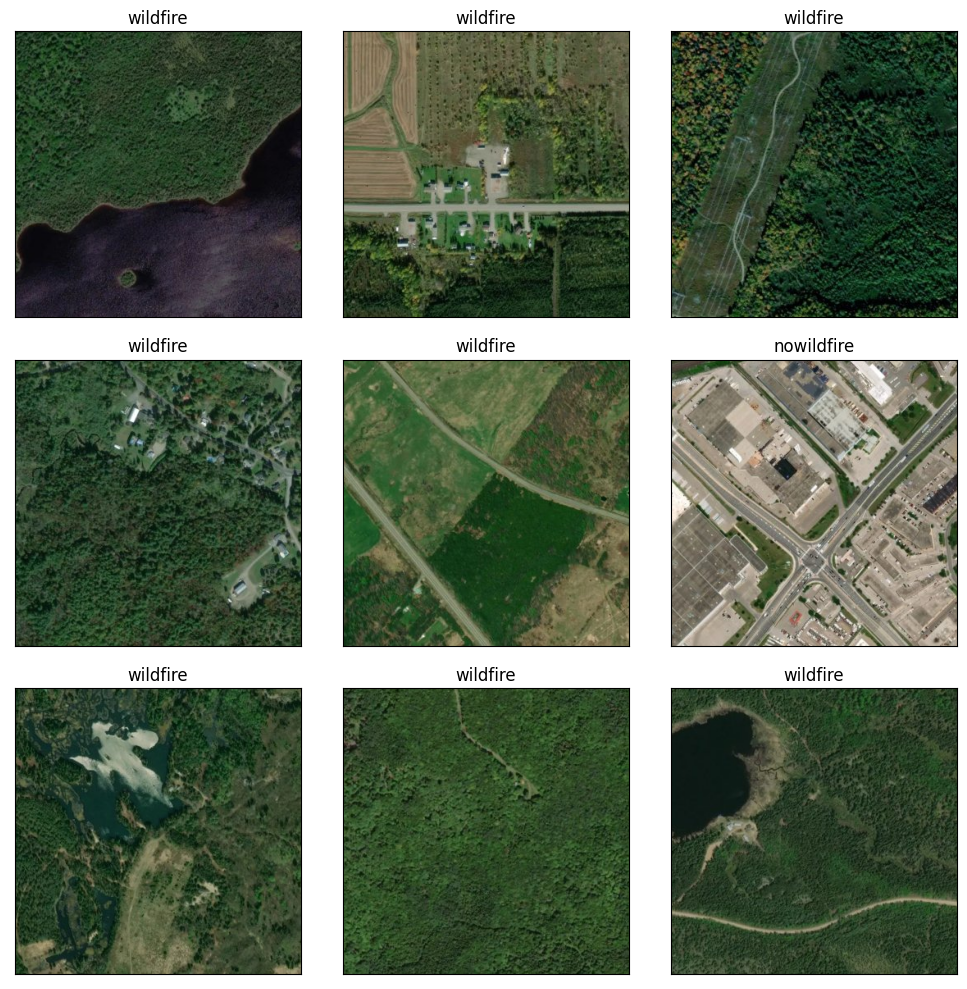

In [20]:


def show_image_sample(df):
    random_data = df.sample(n=9)
    images = np.array([plt.imread(random_data.iloc[i].Filepath) for i in range(9)])
    labels = np.array([random_data.iloc[i].Label for i in range(9)])

    fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(10, 10), subplot_kw={'xticks': [], 'yticks': []})
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i])
        ax.set_title(labels[i])
    plt.tight_layout()
    plt.show()

show_image_sample(train_df)


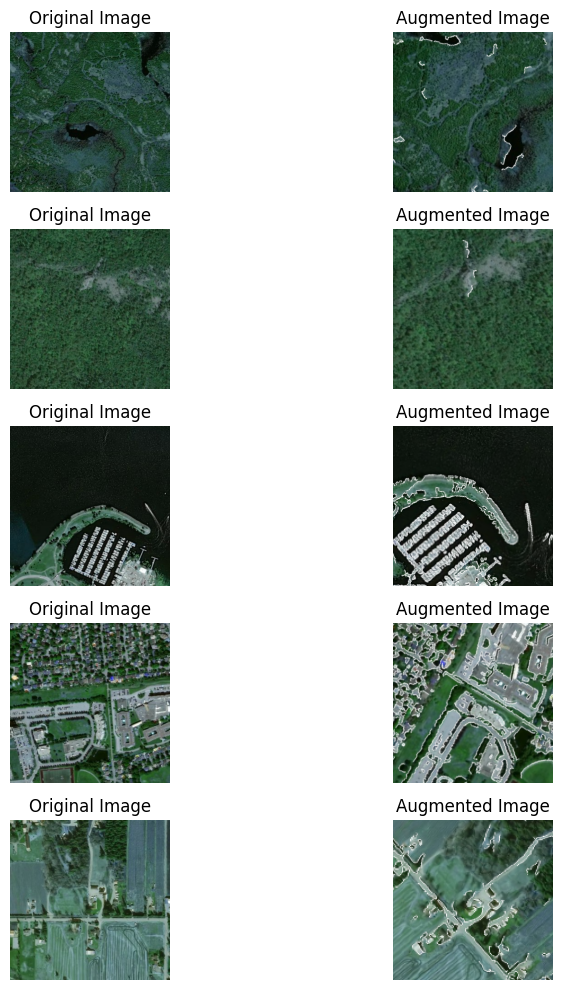

In [21]:


def augment_image(image, augmentations):
    aug = A.Compose(augmentations)
    augmented_image = aug(image=image)['image']
    return augmented_image

def show_original_augment_image(df, num_images, augmentations):
    random_data = df.sample(n=num_images)
    fig, axes = plt.subplots(nrows=num_images, ncols=2, figsize=(10, 10), subplot_kw={'xticks': [], 'yticks': []})
    for i, ax in enumerate(axes):
        image_path = random_data.iloc[i].Filepath
        image = cv2.imread(image_path)

        # Apply Gaussian blur filter
        blurred_image = cv2.GaussianBlur(image, (5, 5), 0)

        # Apply edge detection filter
        gray_image = cv2.cvtColor(blurred_image, cv2.COLOR_BGR2GRAY)
        edges = cv2.Canny(gray_image, 100, 200)

        # Combine the original image with the filtered image
        filtered_image = np.zeros_like(image)
        for channel in range(3):
            filtered_image[:, :, channel] = np.where(edges != 0, edges, image[:, :, channel])

        augmented_image = augment_image(filtered_image, augmentations)

        ax[0].imshow(image)
        ax[0].axis('off')
        ax[0].set_title("Original Image")

        ax[1].imshow(augmented_image)
        ax[1].set_title("Augmented Image")
        ax[1].axis('off')
    plt.tight_layout()
    plt.show()

# Define the augmentation techniques to use
augmentations = [
    A.Flip(),
    A.Rotate(limit=75, always_apply=True),
    A.RandomCrop(width=250, height=250),
    A.RandomScale(scale_limit=(-0.5, 0.5), p=0.5)
]

show_original_augment_image(train_df, 5, augmentations)


In [22]:
BATCH_SIZE = 256
IMG_SIZE = (350, 350)

# Define data generators with augmentations for train set and without augmentations for val/test sets
train_datagen = ImageDataGenerator(
    dtype='float32', 
    rescale=1./255., 
    rotation_range=75,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=[0.9, 1.1],
    shear_range=10,
    zoom_range=0.1,
    fill_mode='nearest',
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=None  # Augmentations already applied above
)

val_datagen = ImageDataGenerator(
    dtype='float32', 
    rescale=1./255.
)

# Define data generators for train, val, and test sets
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='Filepath',
    y_col='Label',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_generator = val_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)


Found 30250 validated image filenames belonging to 2 classes.
Found 6300 validated image filenames belonging to 2 classes.
Found 6300 validated image filenames belonging to 2 classes.


In [25]:

# Define input shape
inputs = Input(shape=(350, 350, 3))

# Add layers to the model
x = Conv2D(filters=16, kernel_size=5, padding='same', kernel_regularizer=l2(0.001))(inputs)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D()(x)

x = Conv2D(filters=32, kernel_size=5, padding='same', kernel_regularizer=l2(0.001))(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D()(x)

x = Conv2D(filters=64, kernel_size=5, padding='same', kernel_regularizer=l2(0.001))(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D()(x)

x = Flatten()(x)

x = Dense(512, kernel_regularizer=l2(0.001))(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(.5)(x)

x = Dense(256, kernel_regularizer=l2(0.001))(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(.3)(x)

# Define the output layer
outputs = Dense(2, activation='softmax')(x)

# Define the model
model = Model(inputs, outputs)

# Define optimizer and compile the model
opt = Adam(learning_rate=0.0001)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])


In [26]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 350, 350, 3)]     0         
                                                                 
 conv2d_3 (Conv2D)           (None, 350, 350, 16)      1216      
                                                                 
 batch_normalization_5 (Batc  (None, 350, 350, 16)     64        
 hNormalization)                                                 
                                                                 
 activation_5 (Activation)   (None, 350, 350, 16)      0         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 175, 175, 16)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 175, 175, 32)      1283

In [27]:


def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def f1_score(y_true, y_pred):
    prec = precision(y_true, y_pred)
    rec = recall(y_true, y_pred)
    return 2*((prec*rec)/(prec+rec+K.epsilon()))

ImageFile.LOAD_TRUNCATED_IMAGES = True

with tf.device('/GPU:0'):
    model.compile(
        optimizer= 'adam',
        loss='categorical_crossentropy',
        metrics=['accuracy', precision, recall, f1_score, 'AUC']
    )
    checkpoint = ModelCheckpoint('model.hdf5', verbose=1, save_best_only=True)
    early_stopping = EarlyStopping(monitor='val_loss', patience=10)

    history = model.fit(train_generator,
                        epochs=20,
                        verbose=1,
                        validation_data=val_generator,
                        callbacks=[checkpoint, early_stopping])

    y_true = test_generator.classes
    y_pred = model.predict(test_generator)
    y_pred_classes = np.argmax(y_pred, axis=1)

    


Epoch 1/20
119/119 [==============================] - ETA: 0s - loss: 1.9855 - accuracy: 0.9169 - precision: 0.9166 - recall: 0.9166 - f1_score: 0.9166 - auc: 0.9721
Epoch 1: val_loss improved from inf to 1.74686, saving model to model.hdf5
119/119 [==============================] - 1012s 8s/step - loss: 1.9855 - accuracy: 0.9169 - precision: 0.9166 - recall: 0.9166 - f1_score: 0.9166 - auc: 0.9721 - val_loss: 1.7469 - val_accuracy: 0.5524 - val_precision: 0.5522 - val_recall: 0.5522 - val_f1_score: 0.5522 - val_auc: 0.7342
Epoch 2/20
119/119 [==============================] - ETA: 0s - loss: 0.7158 - accuracy: 0.9395 - precision: 0.9389 - recall: 0.9389 - f1_score: 0.9389 - auc: 0.9843
Epoch 2: val_loss improved from 1.74686 to 1.57886, saving model to model.hdf5
119/119 [==============================] - 1022s 9s/step - loss: 0.7158 - accuracy: 0.9395 - precision: 0.9389 - recall: 0.9389 - f1_score: 0.9389 - auc: 0.9843 - val_loss: 1.5789 - val_accuracy: 0.5524 - val_precision: 0.552

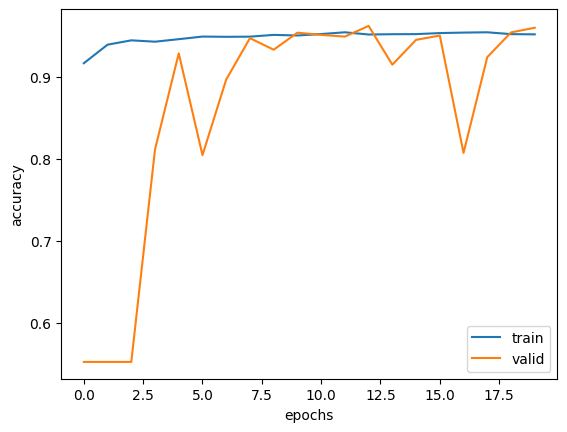

In [28]:
plt.plot(history.history['accuracy'], label = 'train',)
plt.plot(history.history['val_accuracy'], label = 'valid')

# adding legend and labels
plt.legend(loc = 'lower right')
plt.xlabel('epochs')
plt.ylabel('accuracy')

# show the plot
plt.show()

25/25 [==============================] - 33s 1s/step - loss: 0.2016 - accuracy: 0.9692 - precision: 0.9691 - recall: 0.9691 - f1_score: 0.9691 - auc: 0.9955
Test loss: 0.20159530639648438
Test accuracy: 0.9692063331604004
Test precision: 0.9690865278244019
Test recall: 0.9690865278244019
Test F1-score: 0.9690864682197571
Test AUC score: 0.9954612255096436
25/25 [==============================] - 33s 1s/step
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.96      0.97      2820
           1       0.97      0.98      0.97      3480

    accuracy                           0.97      6300
   macro avg       0.97      0.97      0.97      6300
weighted avg       0.97      0.97      0.97      6300

Confusion Matrix:
[[2699  121]
 [  73 3407]]


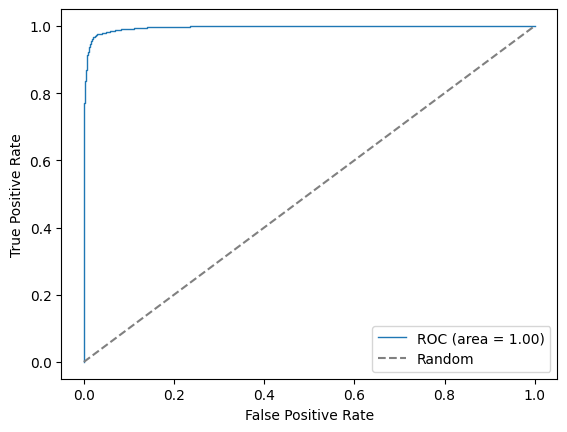

25/25 [==============================] - 32s 1s/step
Accuracy score: 96.92063492063492


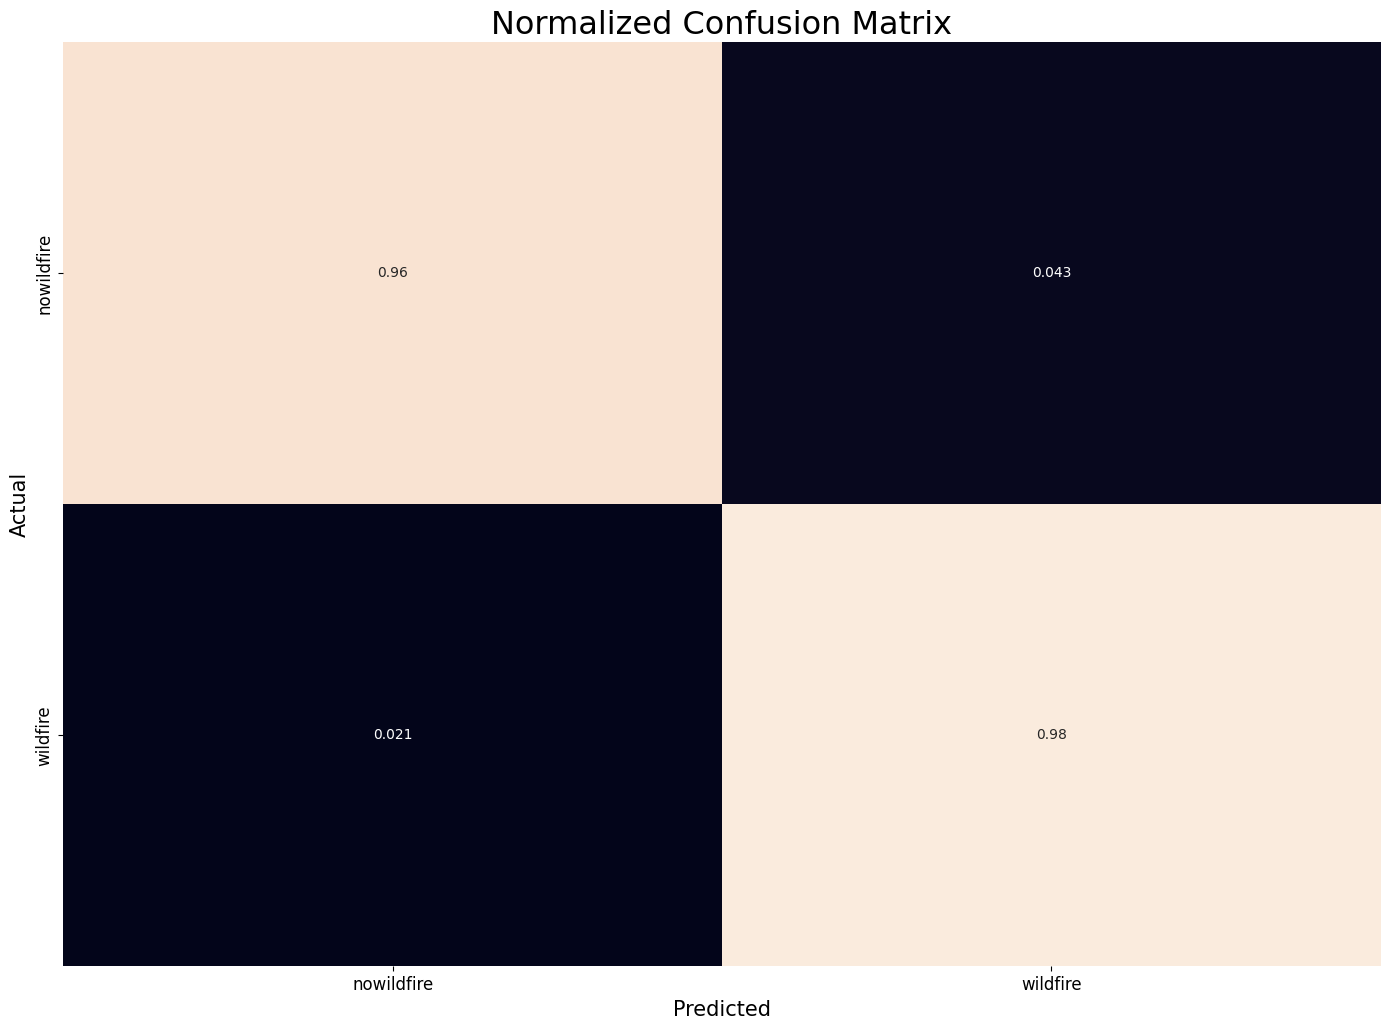

In [29]:
def evaluate_model(model, test_generator, test_df):
    # Evaluate model on test data
    loss, accuracy, precision, recall, f1_score, auc_score = model.evaluate(test_generator)

    print("Test loss:", loss)
    print("Test accuracy:", accuracy)
    print("Test precision:", precision)
    print("Test recall:", recall)
    print("Test F1-score:", f1_score)
    print("Test AUC score:", auc_score)

    # Get predictions
    y_pred = model.predict(test_generator)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = test_generator.classes

    # Print classification report and confusion matrix
    print('Classification Report:')
    print(classification_report(y_true, y_pred_classes))

    print('Confusion Matrix:')
    print(confusion_matrix(y_true, y_pred_classes))

    # Plot ROC curve
    fpr, tpr, thresholds = roc_curve(y_true, y_pred[:, 1])
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, lw=1, label='ROC (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], '--', color='gray', label='Random')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()

    # Get predicted labels and actual labels for confusion matrix
    pred = np.argmax(model.predict(test_generator), axis=1)
    labels = (test_generator.class_indices)
    labels = dict((v,k) for k,v in labels.items())
    pred_label = [labels[k] for k in pred]
    y_test = list(test_df.Label)

    # Print accuracy score and plot confusion matrix
    score = accuracy_score(y_test,pred_label)
    print(f'Accuracy score: {score * 100}')

    cf_matrix = confusion_matrix(y_test, pred_label, normalize='true')
    plt.figure(figsize = (17,12))
    sns.heatmap(cf_matrix, annot=True, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)),cbar=False)
    plt.title('Normalized Confusion Matrix', fontsize = 23)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.xlabel("Predicted", fontsize=15)
    plt.ylabel("Actual", fontsize=15)
    plt.show()

    
evaluate_model(model, test_generator, test_df)


25/25 [==============================] - 33s 1s/step


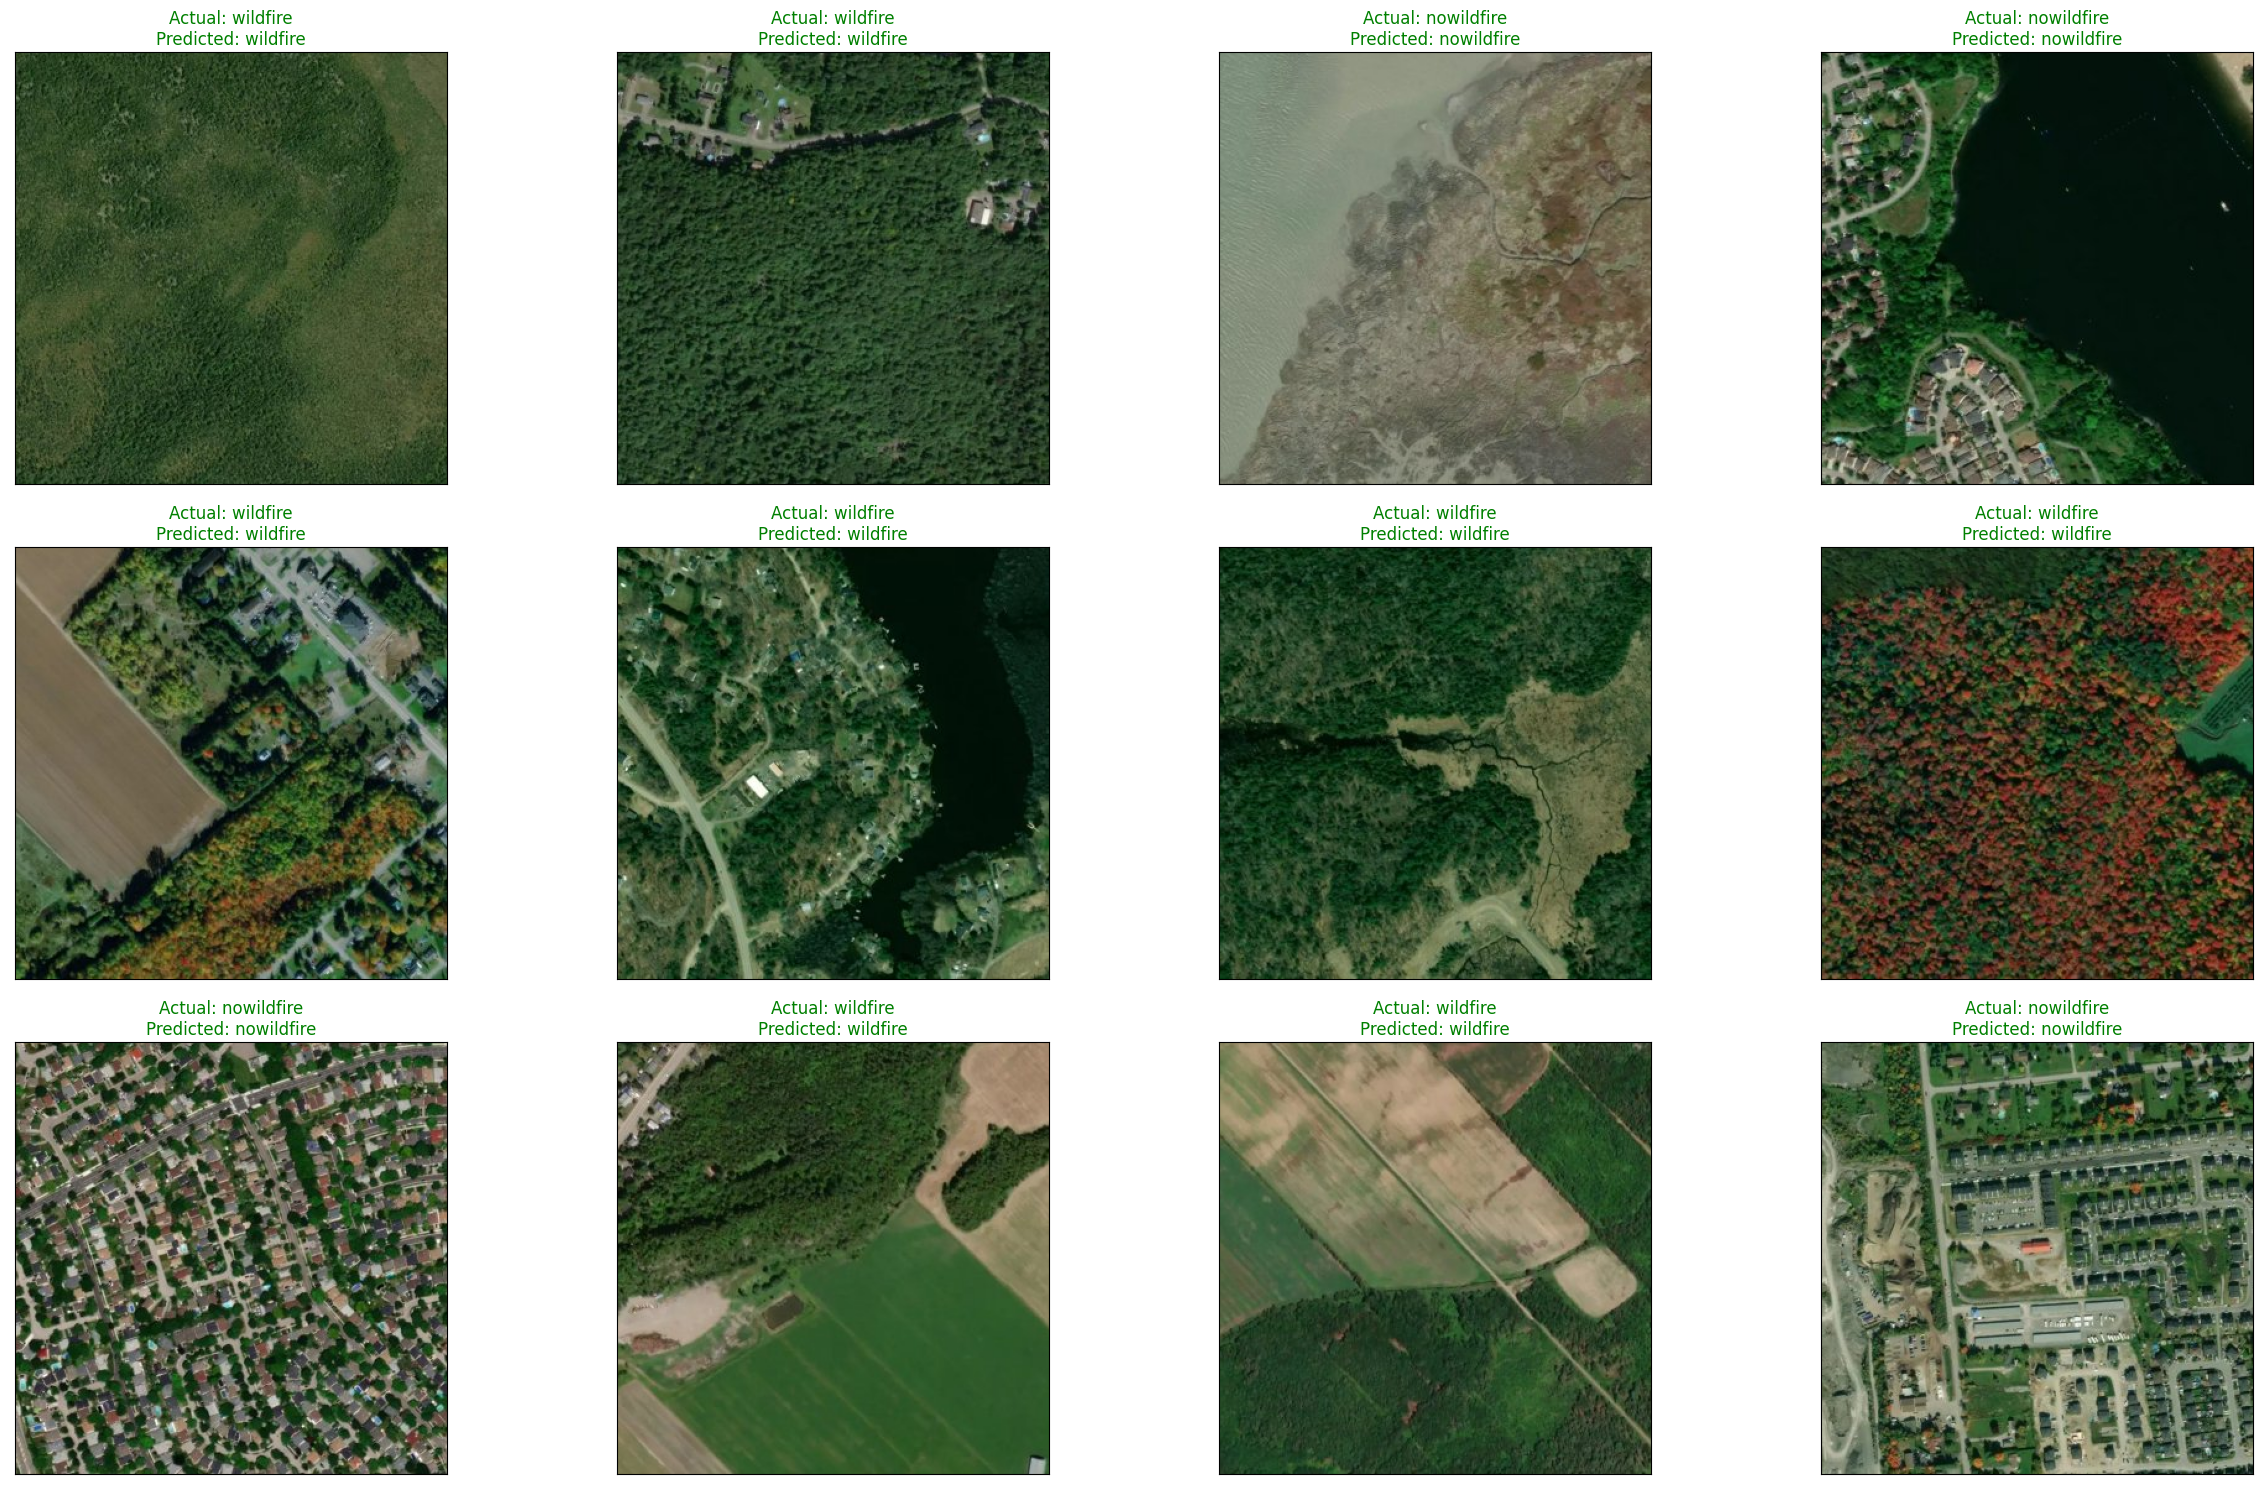

In [31]:
# Predict on test set
pred = np.argmax(model.predict(test_generator), axis=1)

# Get class labels
labels = dict((v,k) for k,v in test_generator.class_indices.items())

# Map predicted values to class labels
pred_label = [labels[k] for k in pred]

# Select random images for display
random_index = np.random.randint(0, len(test_df) - 1, 12)

# Create subplots
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(25, 15),
                         subplot_kw={'xticks': [], 'yticks': []})

# Iterate through subplots and display images with actual and predicted labels
for i, ax in enumerate(axes.flat):
    img_index = random_index[i]
    img_path = test_generator.filepaths[img_index]
    img = plt.imread(img_path)
    ax.imshow(img)
    actual_label = labels[test_generator.labels[img_index]]
    pred_label_i = pred_label[img_index]
    if actual_label == pred_label_i:
        color = "green"
    else:
        color = "red"
    ax.set_title(f"Actual: {actual_label}\nPredicted: {pred_label_i}", color=color)

# Show plot and adjust spacing
plt.tight_layout()
plt.show()
